In [2]:
import numpy as np
import astropy.units as u
from astropy.constants import G
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp, simpson
import matplotlib.pyplot as plt

In [10]:
_mass = []
_radius = []
_inertia = []
with open('mass_radius.txt') as in_file:
    next(in_file)
    for line in in_file:
        m,r,i = [float(e) for e in line.strip().split(',')]
        _mass.append(m)
        _radius.append(r)
        _inertia.append(i)
_mass_to_radius = CubicSpline(_mass, _radius)
_mass_to_inerti = CubicSpline(_mass, _inertia)

@u.quantity_input
def mass_to_radius(mass:u.Quantity[u.M_sun]) -> u.Quantity[u.cm]:
    r = _mass_to_radius(mass.to_value(u.M_sun))*u.R_sun
    return r.to(u.cm)

@u.quantity_input
def mass_to_inertia(mass:u.Quantity[u.M_sun]) -> u.Quantity[u.g*u.cm**2]:
    i = _mass_to_inerti(mass.to_value(u.M_sun))*u.g*u.cm**2
    return i

In [13]:
# Generate radii for CTCV

mass = np.linspace(0.7, 1, 100)*u.M_sun
radii = mass_to_radius(mass)
inertia = mass_to_inertia(mass)

print(radii)
radii = radii.to_value(u.cm)
inertia = inertia.to_value(u.g*u.cm**2)

np.save('../radii.npy', radii)
np.save('../inertia.npy', inertia)

[7.38078326e+08 7.35831168e+08 7.33587907e+08 7.31348470e+08
 7.29112781e+08 7.26880768e+08 7.24652357e+08 7.22427476e+08
 7.20206051e+08 7.17988012e+08 7.15773288e+08 7.13561807e+08
 7.11353499e+08 7.09148294e+08 7.06946123e+08 7.04746916e+08
 7.02550605e+08 7.00357121e+08 6.98166397e+08 6.95978364e+08
 6.93792955e+08 6.91610103e+08 6.89429742e+08 6.87251804e+08
 6.85076224e+08 6.82902935e+08 6.80731872e+08 6.78562970e+08
 6.76396162e+08 6.74231384e+08 6.72068571e+08 6.69907659e+08
 6.67748582e+08 6.65591276e+08 6.63435677e+08 6.61281721e+08
 6.59129343e+08 6.56978481e+08 6.54829069e+08 6.52681044e+08
 6.50534343e+08 6.48388901e+08 6.46244656e+08 6.44101542e+08
 6.41959498e+08 6.39818458e+08 6.37678360e+08 6.35539139e+08
 6.33400733e+08 6.31263077e+08 6.29126107e+08 6.26989759e+08
 6.24853969e+08 6.22718674e+08 6.20583808e+08 6.18449307e+08
 6.16315107e+08 6.14181143e+08 6.12047349e+08 6.09913661e+08
 6.07780013e+08 6.05646340e+08 6.03512575e+08 6.01378652e+08
 5.99244505e+08 5.971100

In [8]:
P = 29.60968584*u.s
M = 0.8*u.M_sun
Mdot = 5e14*u.g/u.s
R = mass_to_radius(M)
I = mass_to_inertia(M)
dM = 0.001*u.M_sun
dI_dm = (I - mass_to_inertia(M+dM))/dM
R_m = np.cbrt(G*M*P*P/(4*np.pi**2))

In [9]:
Pdot = Mdot*(P/I)*(dI_dm + R**2 - R_m**2)

In [10]:
Pdot.decompose()

<Quantity -9.3178486e-17>

Text(0, 0.5, '$\\dot{P}$ [s/s]')

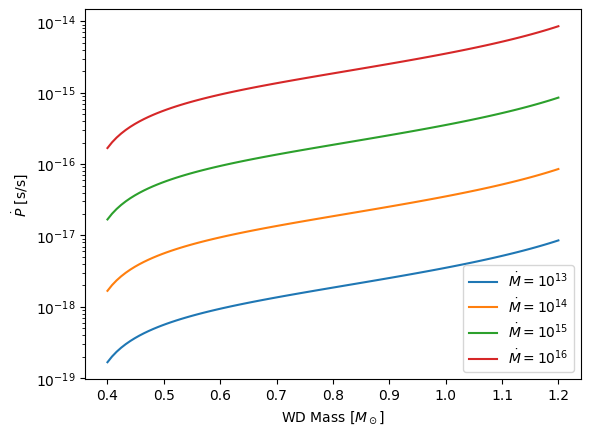

In [32]:
P = 29.60968584*u.s
for Mdot in np.array([1e13, 1e14, 1e15, 1e16])*u.g/u.s:
    M = np.linspace(0.4, 1.2, 100)*u.M_sun
    R = mass_to_radius(M)
    I = mass_to_inertia(M)
    dM = 0.001*u.M_sun
    dI_dm = (I - mass_to_inertia(M+dM))/dM
    R_m = np.cbrt(G*M*P*P/(4*np.pi**2))
    Pdot = Mdot*(P/I)*(dI_dm + R**2 - R_m**2)
    plt.plot(M, np.abs(Pdot.decompose()), label = f'$\\dot{{M}} = 10^{{{int(np.log10(Mdot.value))}}}$')
plt.yscale('log')
plt.legend()
plt.xlabel('WD Mass [$M_\\odot$]')
plt.ylabel('$\\dot{P}$ [s/s]')